In [1]:
import numpy as np
import tensorflow as tf
import pathlib
import argparse
import json
import logging
import pathlib
from time import perf_counter

import tensorflow as tf
from tensorflow_graphics.geometry import transformation
from copy import deepcopy
from colorama import Fore
import pickle

from link_bot_data.dynamics_dataset import DynamicsDataset
from state_space_dynamics import model_utils
from moonshine.gpu_config import limit_gpu_mem
from link_bot_pycommon.pycommon import print_dict
from IPython.display import HTML
from link_bot_pycommon.get_scenario import get_scenario
from link_bot_pycommon.link_bot_scenario import LinkBotScenario
from moonshine.moonshine_utils import dict_of_sequences_to_sequence_of_dicts_tf, dict_of_sequences_to_sequence_of_dicts, numpify
import matplotlib.pyplot as plt
from link_bot_data.classifier_dataset_utils import *
from link_bot_classifiers import classifier_utils
from matplotlib import rc

np.set_printoptions(precision=3, suppress=True, linewidth=200)
plt.style.use("slides")

limit_gpu_mem(2)

In [2]:
take = 100
scenario = get_scenario("link_bot")
dynamics_dataset = DynamicsDataset([pathlib.Path("./fwd_model_data/rope_more_obs_big/")])
tf_dataset = dynamics_dataset.get_datasets(mode='train', take=take)
model_dirs = [pathlib.Path(f"./ss_log_dir/tf2_rope/{i}") for i in range(8)]
fwd_models, _ = model_utils.load_generic_model(model_dirs)

classifier_model_dir = pathlib.Path('log_data/rope_2_seq/May_24_01-12-08_617a0bee2a')
classifier_model = classifier_utils.load_generic_model(classifier_model_dir, scenario=scenario)

Restored from ss_log_dir/tf2_rope/0/ckpt-40
Restored from ss_log_dir/tf2_rope/1/ckpt-44
Restored from ss_log_dir/tf2_rope/2/ckpt-45
Restored from ss_log_dir/tf2_rope/3/ckpt-43
Restored from ss_log_dir/tf2_rope/4/ckpt-40
Restored from ss_log_dir/tf2_rope/5/ckpt-38
Restored from ss_log_dir/tf2_rope/6/ckpt-40
Restored from ss_log_dir/tf2_rope/7/ckpt-49
Restored from log_data/rope_2_seq/May_24_01-12-08_617a0bee2a/ckpt-5


In [3]:
labeling_params = {
    'threshold': 0.10,
    'state_key': 'link_bot',
}

In [ ]:
tf.random.set_seed(0)
transitions = []
# for example in tf_dataset:
#     inputs, outputs = example
#     for start_t  in range(0, dynamics_dataset.max_sequence_length - 2):
#         action = numpify(inputs['action'][start_t])
#         full_env = numpify(inputs['full_env/env'])
#         full_env_extent = numpify(inputs['full_env/extent'])
#         rope_state = numpify(outputs['link_bot'][start_t])
#         next_rope_state = numpify(outputs['link_bot'][start_t + 1])
        
#         transition = (rope_state,
#                       action,
#                       next_rope_state,
#                       full_env,
#                       full_env_extent)
#         transitions.append(transition)

In [5]:
# pickle.dump(transitions, open("transitions_small.pkl", 'wb'))
# transitions = pickle.load(open("transitions_small.pkl", 'rb'))
transitions = pickle.load(open("transitions.pkl", 'rb'))

In [62]:
def close(t_1, t_2, threshold=0.12):
    rope_state_1 = LinkBotScenario.to_rope_local_frame_np(t_1[0])
    rope_state_2 = LinkBotScenario.to_rope_local_frame_np(t_2[0])
    action_1= t_1[1]
    action_2 =t_2[1]
    next_rope_state_1 = LinkBotScenario.to_rope_local_frame_np(t_1[2])
    next_rope_state_2 = LinkBotScenario.to_rope_local_frame_np(t_2[2])
    current_is_close = np.linalg.norm(rope_state_2 - rope_state_1) < threshold 
    action_is_close = np.linalg.norm(action_1 - action_2) < 0.03
    next_is_close = np.linalg.norm(next_rope_state_2 - next_rope_state_1) < threshold 
    return current_is_close and action_is_close and next_is_close

In [63]:
from moonshine.get_local_environment import get_local_env_and_origin
from link_bot_pycommon.link_bot_sdf_utils import compute_extent

def plot_transition(ax, transition, color):
    if ax is None:
        plt.figure()
        ax = plt.gca()
        plt.axis("equal")
    rope_points = np.reshape(transition[0], [-1, 2])
    state = state_from_transition(transition, local_frame=False)
    environment = env_from_transition(transition)
    env = transition[3]
    env_origin = np.array([100, 100], dtype=np.float32)
    local_env_center_point = LinkBotScenario.local_environment_center(state)
    local_env, local_env_origin = get_local_env_and_origin(center_point=local_env_center_point,
                                                             full_env=env,
                                                             full_env_origin=env_origin,
                                                             res=0.01,
                                                             local_h_rows=100,
                                                             local_w_cols=100)
    scenario.plot_state(ax, state, color=color, s=10, zorder=1)
    scenario.plot_action(ax, state, action_from_transition(transition), color='c', s=10, zorder=1)
    s = 0.01 * 100 / 2
    extent_xmin = rope_points[-1][0] - s
    extent_ymin = rope_points[-1][1] - s
    extent_xmax = rope_points[-1][0] + s
    extent_ymax = rope_points[-1][1] + s
    local_env_extent = [extent_xmin, extent_xmax, extent_ymin, extent_ymax]
    ax.imshow(np.flipud(local_env), extent=local_env_extent, cmap='Greys')

In [64]:
def state_from_transition(transition, local_frame=False):
    rope_state = transition[0]
    if local_frame:
        rope_state = LinkBotScenario.to_rope_local_frame_np(rope_state)
    return {
        'link_bot': rope_state,
    }

def next_state_from_transition(transition, current_local_frame=False):
    current_rope_state = transition[0]
    next_rope_state = transition[2]
    if current_local_frame:
        rope_state = LinkBotScenario.to_rope_local_frame_np(next_rope_state, current_rope_state)
    return {
        'link_bot': rope_state,
    }

def action_from_transition(transition):
    return transition[1]

def env_from_transition(transition):
    return {
        'full_env/env': transition[3],
        'full_env/extent': transition[4]
    }

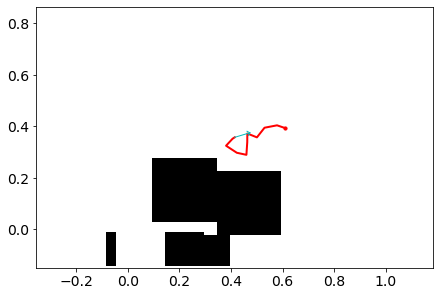

In [65]:
plot_transition(ax=None, transition=transitions[78], color='r')

In [66]:
transition_1 = transitions[41]
nearby_transitions = []
for transition_2 in transitions:
    if not np.all(transition_1[0] == transition_2[0]):
        if close(transition_1, transition_2):
            nearby_transitions.append(transition_2)
            if len(nearby_transitions) > 50:
                break

In [68]:
len(nearby_transitions)

1

In [51]:
from tensorflow_graphics.geometry import transformation
from scipy import ndimage
from moonshine.image_functions import rotate_image

def plot_transition_rope_frame(ax, transition, color):
    if ax is None:
        plt.figure()
        ax = plt.gca()
        plt.axis("equal")
    rope_points = np.reshape(transition[0], [-1, 2])
    state = state_from_transition(transition, local_frame=False)
    state_local = state_from_transition(transition, local_frame=True)
    next_state_local = next_state_from_transition(transition, current_local_frame=True)
    environment = env_from_transition(transition)
    env = transition[3]
    env_origin = np.array([100, 100], dtype=np.float32)
    local_env_center_point = LinkBotScenario.local_environment_center(state)
    local_env, local_env_origin = get_local_env_and_origin(center_point=local_env_center_point,
                                                             full_env=env,
                                                             full_env_origin=env_origin,
                                                             res=0.01,
                                                             local_h_rows=100,
                                                             local_w_cols=100)
    
    deltas = rope_points[1:] - rope_points[:-1]
    last_dxs = deltas[-1, 0]
    last_dys = deltas[-1, 1]
    angle_of_last_link = tf.atan2(last_dys, last_dxs)
    angle_of_last_link_deg = np.rad2deg(angle_of_last_link)
    local_env_rope_frame = ndimage.rotate(local_env, angle_of_last_link_deg, reshape=False, prefilter=False)
#     print(rope_points[-1])
#     local_env_rope_frame = ndimage.shift(local_env_rope_frame, rope_points[-1])
    action = action_from_transition(transition)
    action_rotation_matrix = transformation.rotation_matrix_2d.from_euler([-angle_of_last_link])
    action_rope_frame = transformation.rotation_matrix_2d.rotate(action, action_rotation_matrix)
    s = 0.01 * 100 / 2
    extent_xmin = -s
    extent_ymin = -s
    extent_xmax = s
    extent_ymax = s
    local_env_extent = [extent_xmin, extent_xmax, extent_ymin, extent_ymax]
    
    scenario.plot_state(ax, state_local, color='r', s=10, zorder=1)
    scenario.plot_state(ax, next_state_local, color='orange', s=10, zorder=1, alpha=0.5)
    scenario.plot_action(ax, state_local, action_rope_frame, color='c', s=10, zorder=1)
    ax.imshow(np.flipud(local_env_rope_frame), extent=local_env_extent, cmap='Greys')

0.0
0.0


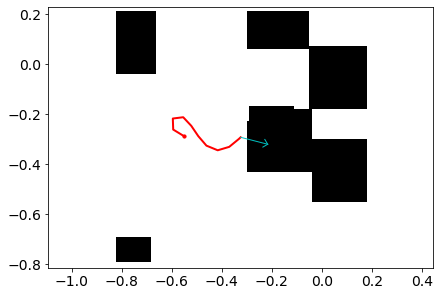

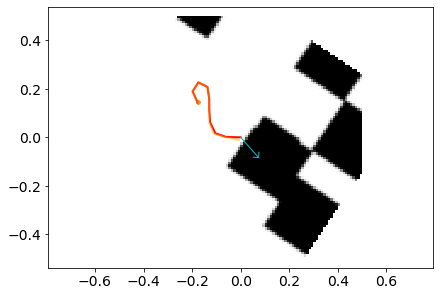

In [52]:
%matplotlib inline

plot_transition(ax=None, transition=transition_1, color='r')
for nearby_transition in nearby_transitions[:10]:
    plot_transition_rope_frame(ax=None, transition=nearby_transition, color='r')

In [ ]:
def compute_volume(state, nearby_states):
    distances = np.linalg.norm(state - nearby_states)
    radius = np.max(distances)
    # radius to the power of the dimension is proportional to the volume
    dim = state.shape[0]
    return radius ** dim


def divergence_ratio(transition, nearby_transitions):
    current_state = transition[0]
    nearby_current_states = [t[0] for t in nearby_transitions]
    current_volume = compute_volume(current_state, nearby_current_states)

    next_state = transition[2]
    nearby_next_states = [t[2] for t in nearby_transitions]
    next_volume = compute_volume(next_state, nearby_next_states)
    
    return next_volume / current_volume

def is_funneling(transition, nearby_transitions):
    return divergence_ratio(transition, nearby_transitions) < 1
    
is_funneling(transition_1, nearby_transitions)